In [1]:
import pandas as pd
import scipy.signal as scisig
import os
import numpy as np
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

In [2]:
subject_code = 'I'
task = 'task4'

f = 4  # サンプリング周波数
threshold = 0.01  # 閾値（振幅がこれより大きいものをSCRとして検出）

df_EDA = pd.read_csv("../data/" + subject_code + "/EDA/EDA_" + task + ".csv", index_col = 0)
df_EDA.head()

,t,EDA
0,0.00,0.821917
1,0.25,0.821917
2,0.50,0.823198
3,0.75,0.824480
4,1.00,0.820635


In [3]:
df_EDA['filtered_eda'] =  butter_lowpass_filter(df_EDA['EDA'], 1.0, f, order=5)
df_EDA

,t,EDA,filtered_eda
0,0.00,0.821917,0.043386
1,0.25,0.821917,0.260316
2,0.50,0.823198,0.666762
3,0.75,0.824480,0.963617
4,1.00,0.820635,0.921483
...,...,...,...
751,187.75,0.832170,0.823899
752,188.00,0.828325,0.823448
753,188.25,0.827044,0.828158
754,188.50,0.827044,0.830869


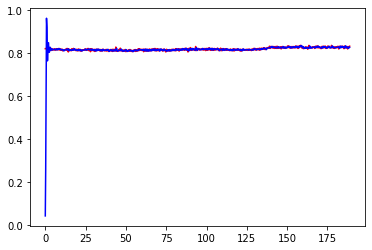

In [4]:
fig, ax = plt.subplots()
ax.plot(df_EDA['t'], df_EDA['EDA'], color='red')
ax.plot(df_EDA['t'], df_EDA['filtered_eda'], color='blue')

In [5]:
EDA_shift = df_EDA['filtered_eda'][1:].values - df_EDA['filtered_eda'][:-1].values

In [6]:
peaks = np.zeros(len(EDA_shift))
peak_sign = np.sign(EDA_shift)
bottoms = np.zeros(len(EDA_shift))
peak_starts = np.zeros(len(EDA_shift))

for i in range(len(EDA_shift)-1):
    if peak_sign[i] == -1 and peak_sign[i+1] == 1:
        bottoms[i+1] = 1
    if peak_sign[i] == 1 and peak_sign[i+1] == -1:
        peaks[i+1] = 1

peak_locs = np.where(peaks==1)
bottom_locs = np.where(bottoms==1)
df_peak = pd.Series(peak_locs[0], name='Peak')
df_bottom = pd.Series(bottom_locs[0], name='Bottom')

if df_peak[0] < df_bottom[0]:
    df_peak = df_peak[1:].reset_index(drop=True)
if df_peak[len(df_peak)-1] < df_bottom[len(df_bottom)-1]:
    df_bottom = df_bottom[:-1].reset_index(drop=True)

print(df_peak, df_bottom)
    

0        7
1       12
2       16
3       21
4       24
      ... 
172    737
173    741
174    745
175    749
176    754
Name: Peak, Length: 177, dtype: int64 0        5
1       10
2       14
3       19
4       22
      ... 
172    735
173    739
174    743
175    748
176    752
Name: Bottom, Length: 177, dtype: int64


In [7]:
PeakInfo = pd.concat([df_peak,df_bottom], axis=1)
PeakInfo['PeakStart'] = PeakInfo['Bottom']

for i in range(len(PeakInfo)-1):
    if i == 0:
        pass
    else:
        if PeakInfo['Peak'][i] - PeakInfo['Peak'][i-1] < 4:
            if df_EDA['filtered_eda'][PeakInfo['Bottom'][i]] >= df_EDA['filtered_eda'][PeakInfo['PeakStart'][i-1]] :
                PeakInfo['PeakStart'][i] = PeakInfo['PeakStart'][i-1]
            else:
                pass


PeakInfo['PeakValue'] = df_EDA['filtered_eda'][PeakInfo['Peak']].reset_index(drop=True)
PeakInfo['PeakStartValue'] = df_EDA['filtered_eda'][PeakInfo['PeakStart']].reset_index(drop=True)
PeakInfo['Amplitude'] = PeakInfo['PeakValue'] - PeakInfo['PeakStartValue']
print(PeakInfo)


     Peak  Bottom  PeakStart  PeakValue  PeakStartValue  Amplitude
0       7       5          5   0.849414        0.765079   0.084335
1      12      10         10   0.828745        0.804773   0.023971
2      16      14         14   0.822007        0.813270   0.008737
3      21      19         19   0.818257        0.815803   0.002453
4      24      22         19   0.820080        0.815803   0.004277
..    ...     ...        ...        ...             ...        ...
172   737     735        735   0.833096        0.827142   0.005954
173   741     739        739   0.830946        0.827399   0.003547
174   745     743        743   0.835420        0.823943   0.011478
175   749     748        748   0.829438        0.826393   0.003045
176   754     752        752   0.830869        0.823448   0.007422

[177 rows x 6 columns]


In [8]:

SCR_Param = PeakInfo[ PeakInfo['Amplitude'] > threshold ].reset_index(drop=True)
SCR_Param['RiseTime'] = (SCR_Param['Peak'] - SCR_Param['PeakStart']) / f
SCR_Param['HalfRecoveryTime'] = 0

half_times = []
HalfRecovery_window = 100  # 1/2回復時間を探すときのウィンドウ

for i in range(len(SCR_Param)):
    peak_loc = SCR_Param['Peak'][i]
    half_loc = peak_loc
    half_amplitude = SCR_Param['Amplitude'][i] * 0.5
    found = 0
    while half_loc < half_loc + HalfRecovery_window and found == 0 and half_loc < len(df_EDA):
        if half_amplitude <= df_EDA['filtered_eda'][peak_loc] -df_EDA['filtered_eda'][half_loc]:              
            # SCR_Param['HalfRecoveryTime'][i] =  (half_loc - peak_loc) / f
            half_times = np.append(half_times, (half_loc - peak_loc) / f)
            found = 1
            
        half_loc += 1
    if found == 0:
        # SCR_Param['HalfRecoveryTime'][i] = HalfRecovery_window
        half_times = np.append(half_times, 0)

SCR_Param['HalfRecoveryTime'] = half_times

SCR_Param.rename(columns={'Peak': 'PeakTime', 'Bottom': 'BottomTime', 'PeakStart': 'PeakStartTime'}, inplace=True)

SCR_Param['PeakTime'] = SCR_Param['PeakTime'] / f
SCR_Param['BottomTime'] = SCR_Param['BottomTime'] / f
SCR_Param['PeakStartTime'] = SCR_Param['PeakStartTime'] / f

SCR_Param.to_csv("../data/" + subject_code + "/SCR/SCR_" + task + ".csv")

SCR_Param.head()

,PeakTime,BottomTime,PeakStartTime,PeakValue,PeakStartValue,Amplitude,RiseTime,HalfRecoveryTime
0,1.75,1.25,1.25,0.849414,0.765079,0.084335,0.50,0.50
1,3.00,2.50,2.50,0.828745,0.804773,0.023971,0.50,0.25
2,44.25,43.50,43.50,0.823528,0.811343,0.012185,0.75,0.25
3,71.75,71.00,71.00,0.820860,0.810630,0.010229,0.75,0.50
4,89.50,89.00,89.00,0.822841,0.811030,0.011812,0.50,0.50


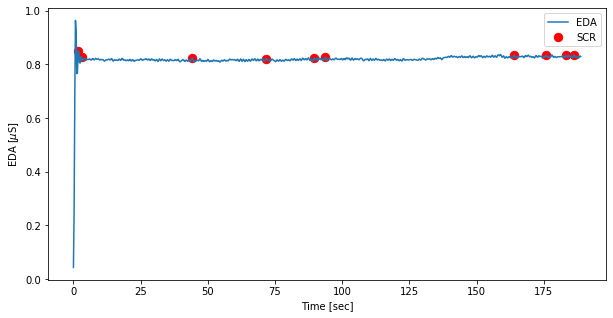

In [9]:
n = len(df_EDA)
t = np.arange(0, n * 1/f, 1/f)


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, df_EDA['filtered_eda'], label='EDA')
ax.scatter(SCR_Param['PeakTime'], SCR_Param['PeakValue'], c='red', s=70, label='SCR')
ax.set_xlabel('Time [sec]')
ax.set_ylabel('EDA [$\mu$S]')
ax.legend(loc='best')
# ax.set_xlim(10,)
plt.rcParams['figure.dpi'] = 300
# plt.savefig('C7_EDA3.jpg', bbox_inches="tight", pad_inches=0.05)
plt.show()


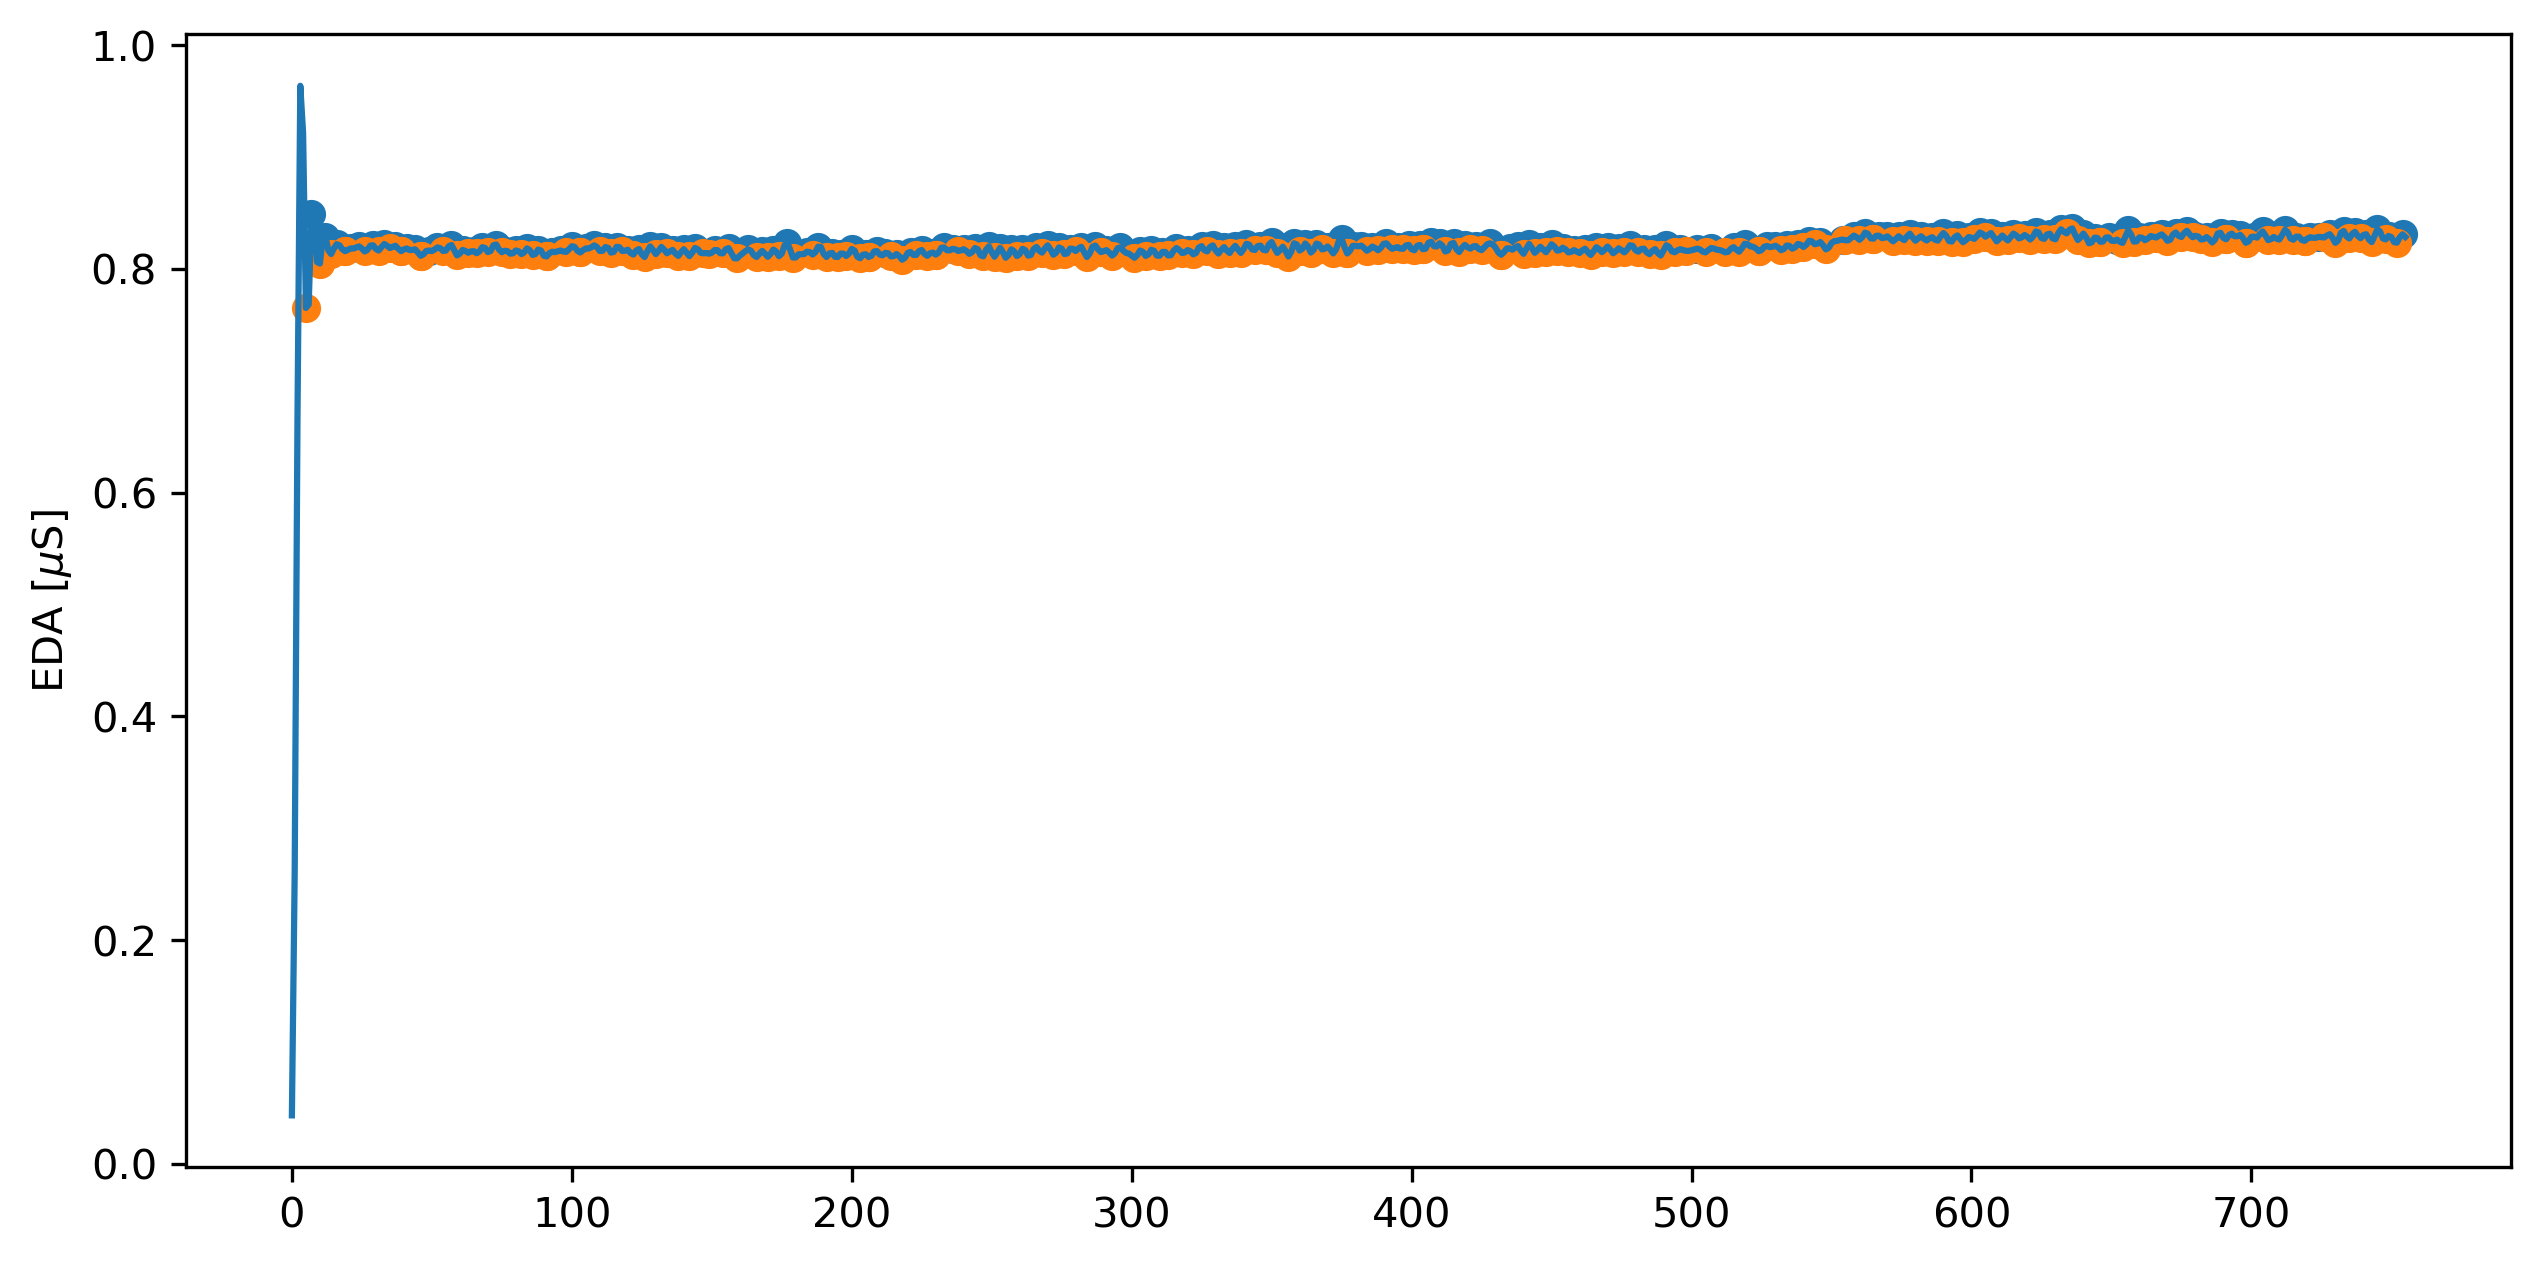

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_EDA['filtered_eda'])
ax.scatter(PeakInfo['Peak'], df_EDA['filtered_eda'][PeakInfo['Peak']])
# ax.scatter(PeakInfo['Peak']/f, df_EDA['filtered_eda'][PeakInfo['Peak']])
ax.scatter(PeakInfo['PeakStart'], df_EDA['filtered_eda'][PeakInfo['PeakStart']])
# ax.scatter(PeakInfo['PeakStart']/f, df_EDA['filtered_eda'][PeakInfo['PeakStart']])
ax.set_ylabel('EDA [$\mu$S]')
plt.show()